In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols

DATA UNDERSTANDING AND PREPROCESSING

Operations:

    1. Checked data types, column names, and unique values.
    
    2. Verified there were no missing values in the dataset.

Basic Data Exploration

In [160]:
df = pd.read_csv(r"datasets\raw.csv")

# Additional data exploration beyond what was shown
# Check data types and verify no unexpected values
print(df['Neighborhood_Quality'].unique())
print(df.columns)

['Average' 'Excellent' 'Good' 'Poor']
Index(['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built',
       'Lot_Size', 'Garage_Size', 'Neighborhood_Quality', 'House_Price'],
      dtype='object')


In [161]:
# Create derived features that might be helpful
df['Age'] = 2025 - df['Year_Built']  # Current year minus year built
df['Price_Per_SqFt'] = df['House_Price'] / df['Square_Footage']

In [162]:
df.head(5)

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price,Age,Price_Per_SqFt
0,1360,2,1,1981,0.599637,0,Average,2.623829e+05,44,192.928568
1,4272,3,3,2016,4.753014,1,Average,9.852609e+05,9,230.632222
2,3592,1,2,2016,3.634823,0,Excellent,7.779774e+05,9,216.586133
3,966,1,2,1977,2.730667,1,Good,2.296989e+05,48,237.783560
4,4926,2,1,1993,4.699073,0,Good,1.041741e+06,32,211.478047


Data Cleaning Verification

In [163]:
def outliers(df, column):
    Q1 = np.percentile(df[column], 25) 
    Q3 = np.percentile(df[column], 75) 

    IQR=Q3-Q1

    LF= Q1-1.5*(IQR)
    UF= Q3+1.5*(IQR)

    outlier=df[(df[column]>UF) & (df[column]<LF)]
    return outlier 

for i in df.columns:
    if(df[i].dtypes in ("int64","float64")):
        print(f"Number of {i} outliers: {len(outliers(df,i))}")

Number of Square_Footage outliers: 0
Number of Num_Bedrooms outliers: 0
Number of Num_Bathrooms outliers: 0
Number of Year_Built outliers: 0
Number of Lot_Size outliers: 0
Number of Garage_Size outliers: 0
Number of House_Price outliers: 0
Number of Age outliers: 0
Number of Price_Per_SqFt outliers: 0


Conclusions:

    1.The dataset is clean, with no missing values.

    2.The Neighborhood_Quality column is categorical, while other columns are numerical.

    3.Derived features like Age (based on Year_Built) and Price_Per_SqFt (based on Square_Footage and House_Price) can provide additional insights.

UNIVARIATE ANALYSIS

Operations:

    1.Analyzed statistical summaries (mean, median, standard deviation, skewness, kurtosis).

    2.Plotted histograms for numerical features.



Numerical Features Distribution

In [164]:
# Statistical summary with additional metrics

numerical_features=['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms','Year_Built', 'Lot_Size', 'Garage_Size', 'House_Price']

for feature in numerical_features:
    print(f"\nSummary for {feature}:")
    summary = pd.DataFrame({
        'Mean': [np.mean(df[feature])],
        'Median': [np.median(df[feature])],
        'Std Dev': [np.std(df[feature])],
        'Skewness': [df[feature].skew()],
        'Kurtosis': [df[feature].kurt()],
        'Min': [np.min(df[feature])],
        'Max': [np.max(df[feature])]
    })
    print(summary)


Summary for Square_Footage:
       Mean  Median      Std Dev  Skewness  Kurtosis  Min   Max
0  2815.422  2862.5  1254.887006 -0.066001 -1.128061  503  4999

Summary for Num_Bedrooms:
   Mean  Median  Std Dev  Skewness  Kurtosis  Min  Max
0  2.99     3.0  1.42685  0.025884 -1.333604    1    5

Summary for Num_Bathrooms:
    Mean  Median   Std Dev  Skewness  Kurtosis  Min  Max
0  1.973     2.0  0.819921  0.049917 -1.512391    1    3

Summary for Year_Built:
      Mean  Median    Std Dev  Skewness  Kurtosis   Min   Max
0  1986.55  1986.0  20.622597 -0.021254 -1.185454  1950  2022

Summary for Lot_Size:
       Mean   Median   Std Dev  Skewness  Kurtosis       Min       Max
0  2.778087  2.80974  1.297254 -0.044288 -1.200895  0.506058  4.989303

Summary for Garage_Size:
    Mean  Median   Std Dev  Skewness  Kurtosis  Min  Max
0  1.022     1.0  0.814565   -0.0404 -1.493259    0    2

Summary for House_Price:
            Mean        Median        Std Dev  Skewness  Kurtosis  \
0  618861.01864

In [165]:
# Set up visualization style

sns.set_style('whitegrid')
sns.set_palette("Set2")

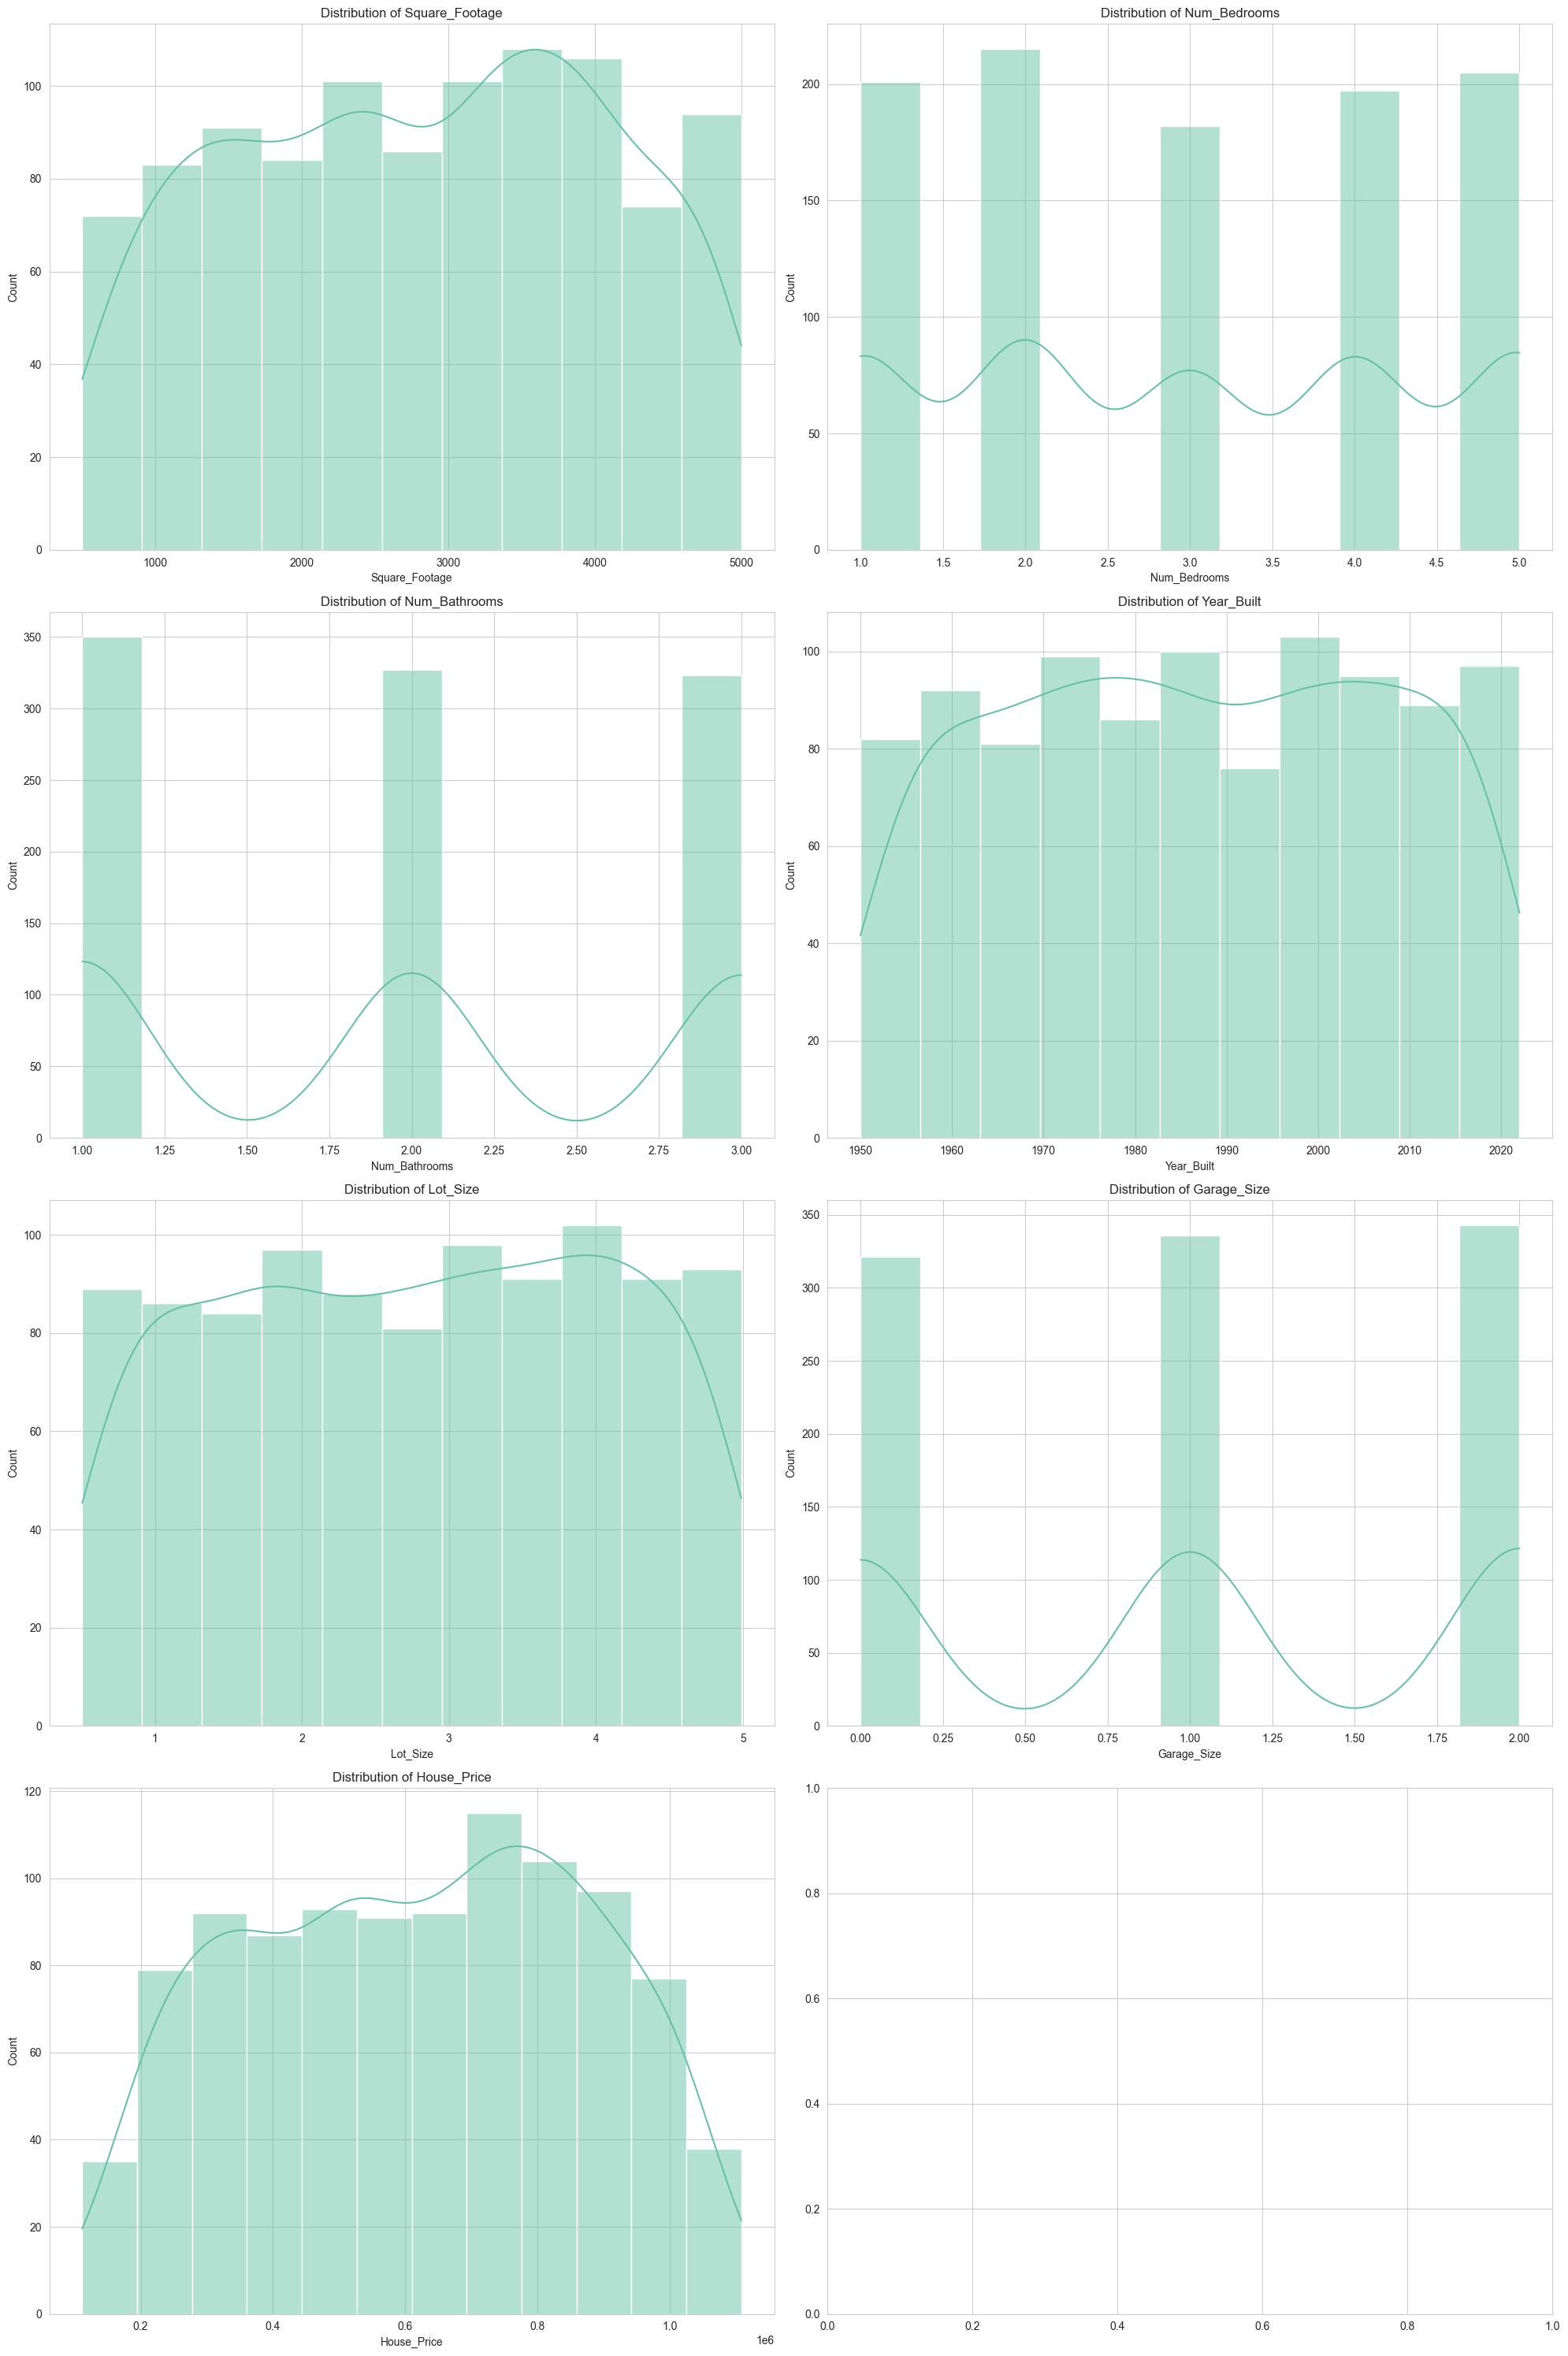

In [166]:
fig, axes = plt.subplots(4, 2, figsize=(20, 30))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    if i < len(axes):
        sns.histplot(df[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        
plt.tight_layout()
plt.show()

Conclusions:

    1.Square Footage: Right-skewed distribution; most houses are smaller in size, with a few very large properties.

    2.Number of Bedrooms/Bathrooms: Most houses have 2–4 bedrooms and 1–3 bathrooms.

    3.Year Built: Majority of houses were built after 1950, with a peak in recent decades.

    4.Lot Size: Highly skewed; most houses have small lots, but a few have very large ones.

    5.House Price: Right-skewed; most houses fall within a moderate price range, with some high-value outliers.

    6.Skewness in key features suggests potential need for transformations during modeling.

CATEGORICAL FEATURE ANALYSIS

Operations:

    1.Analyzed the distribution of Neighborhood_Quality.

    2.Examined average house prices for each neighborhood quality level using bar plots and box plots.

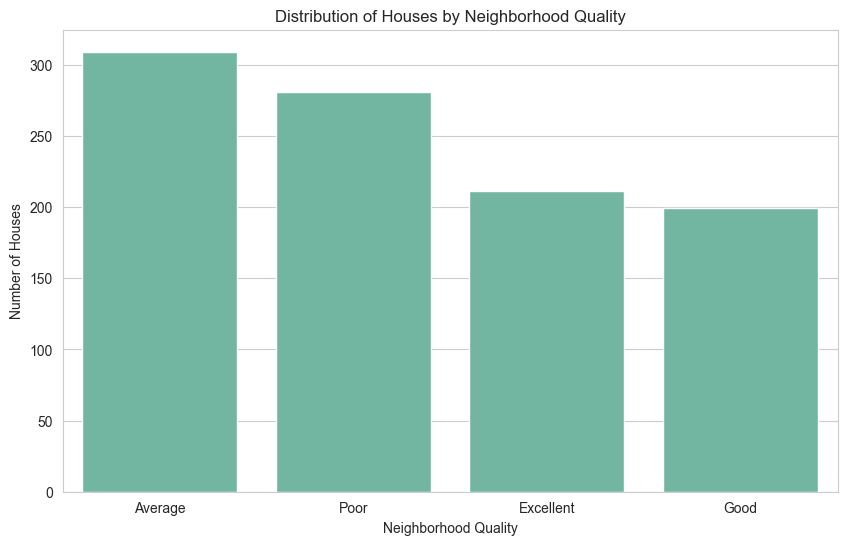

In [167]:
# Analyze neighborhood quality distribution
neighborhood_counts = df['Neighborhood_Quality'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=neighborhood_counts.index, y=neighborhood_counts.values)
plt.title('Distribution of Houses by Neighborhood Quality')
plt.ylabel('Number of Houses')
plt.xlabel('Neighborhood Quality')
plt.show()

In [168]:
# Average house price by neighborhood
neighborhood_price = df.groupby('Neighborhood_Quality')['House_Price'].agg(['mean', 'median', 'std', 'count'])
print(neighborhood_price)

                               mean       median            std  count
Neighborhood_Quality                                                  
Average               605864.586698  602549.2782  256963.085226    309
Excellent             611981.884961  644601.1052  249079.788441    211
Good                  640028.741444  654466.9454  251616.087737    199
Poor                  623327.274314  647832.2076  254770.209057    281


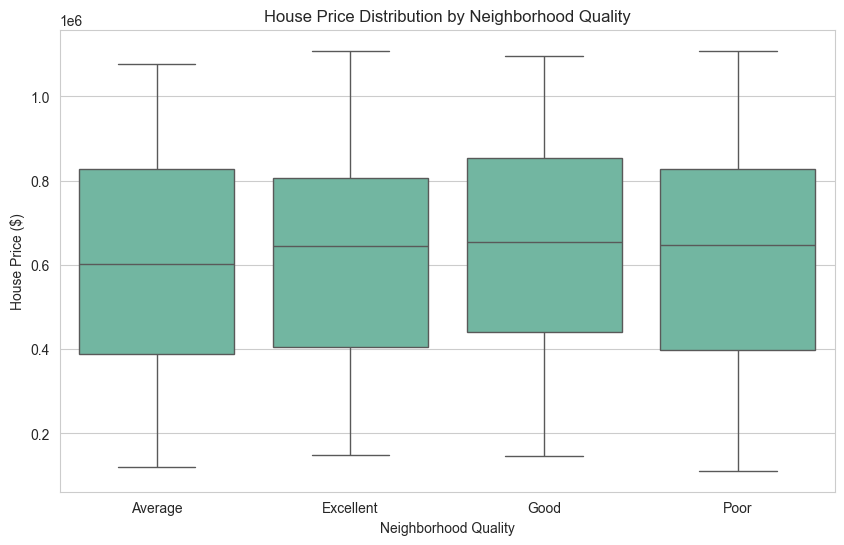

In [169]:
# Visualize price distribution by neighborhood
plt.figure(figsize=(10, 6))
sns.boxplot(x='Neighborhood_Quality', y='House_Price', data=df)
plt.title('House Price Distribution by Neighborhood Quality')
plt.ylabel('House Price ($)')
plt.xlabel('Neighborhood Quality')
plt.show()

Conclusions:

    1.Neighborhood quality is well-distributed across categories.

    2.Higher neighborhood quality correlates with higher average house prices.

    3.Significant price variability exists within each neighborhood quality level, indicating other factors also influence prices.

 BIVARIATE ANALYSIS

Operations:

    1.Correlation heatmap to assess relationships between numerical features.

    2.Scatter plots and regression lines for key variables against house price.

Correlation Analysis

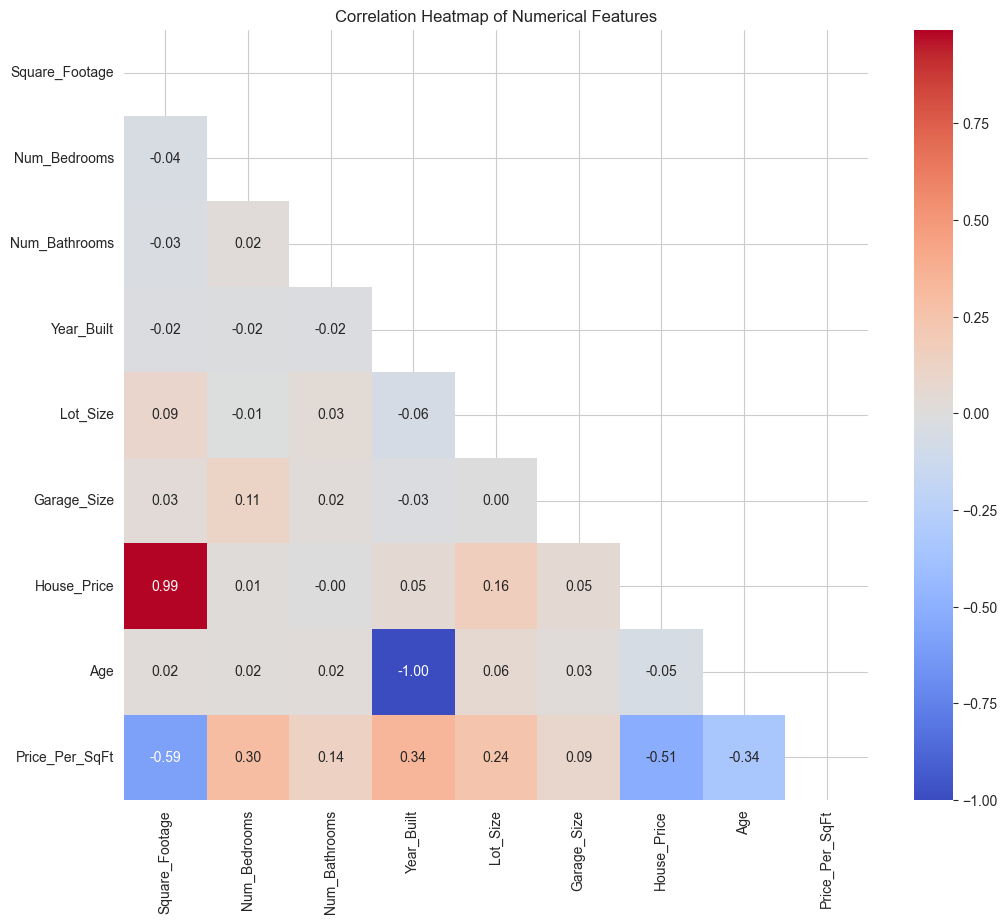

In [170]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
correlation_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [171]:
# Detailed price correlation analysis
price_correlations = correlation_matrix['House_Price'].sort_values(ascending=False)
print("Correlations with House Price:")
print(price_correlations)

Correlations with House Price:
House_Price       1.000000
Square_Footage    0.991261
Lot_Size          0.160412
Garage_Size       0.052133
Year_Built        0.051967
Num_Bedrooms      0.014633
Num_Bathrooms    -0.001862
Age              -0.051967
Price_Per_SqFt   -0.511148
Name: House_Price, dtype: float64


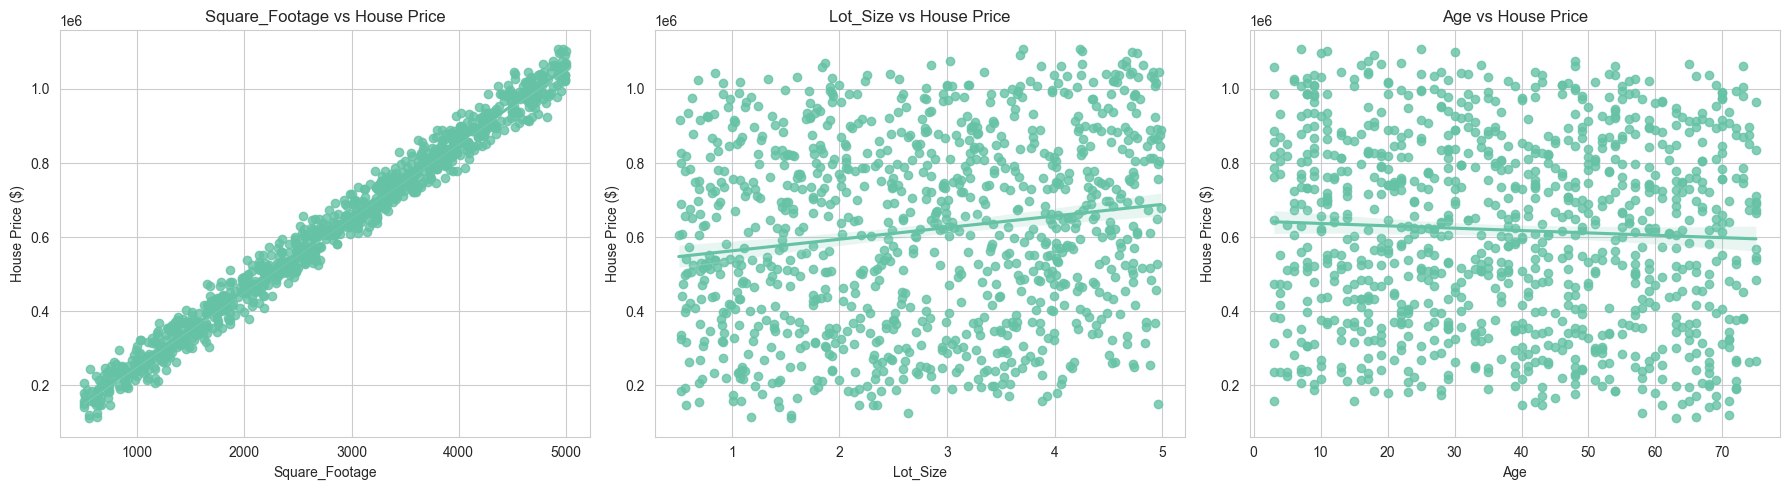

In [172]:
# Key scatter plots with regression lines
key_features = ['Square_Footage', 'Lot_Size', 'Age']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(key_features):
    sns.regplot(x=feature, y='House_Price', data=df, ax=axes[i])
    axes[i].set_title(f'{feature} vs House Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('House Price ($)')
    
plt.tight_layout()
plt.show()

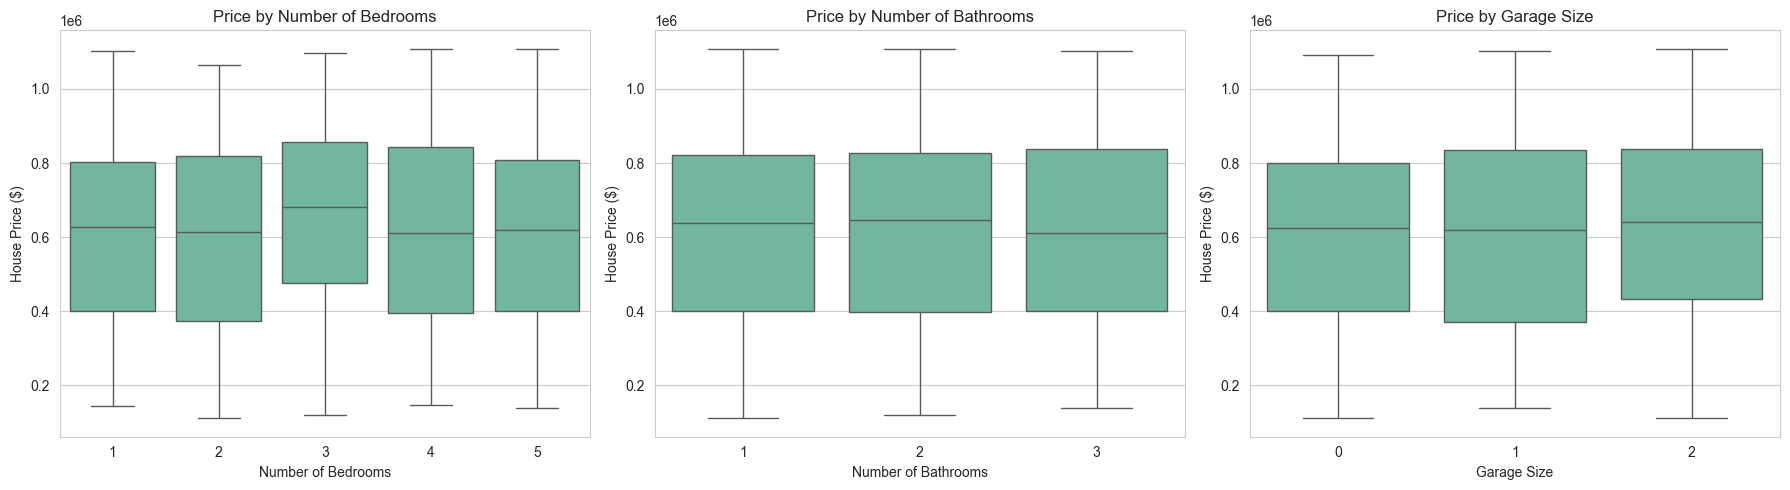

In [173]:
# Categorical feature relationships
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Num_Bedrooms', y='House_Price', data=df, ax=axes[0])
axes[0].set_title('Price by Number of Bedrooms')
axes[0].set_xlabel('Number of Bedrooms')
axes[0].set_ylabel('House Price ($)')

sns.boxplot(x='Num_Bathrooms', y='House_Price', data=df, ax=axes[1])
axes[1].set_title('Price by Number of Bathrooms')
axes[1].set_xlabel('Number of Bathrooms')
axes[1].set_ylabel('House Price ($)')

sns.boxplot(x='Garage_Size', y='House_Price', data=df, ax=axes[2])
axes[2].set_title('Price by Garage Size')
axes[2].set_xlabel('Garage Size')
axes[2].set_ylabel('House Price ($)')

plt.tight_layout()
plt.show()


Conclusions:

    1.Square Footage has the strongest positive correlation with house price (r≈0.8).

    2.Lot Size, Number of Bathrooms, and Garage Size also show moderate positive correlations with house price.

    3.Weak or no correlation between Year Built and house price suggests that age alone is not a strong predictor of value.

    4.Outliers in features like Lot Size and House Price may influence correlations and require careful handling during modeling.

MUTLIVARIATE ANALYSIS

Operations:

    1.Pair plots to visualize relationships among multiple variables.

    2.Joint plots to analyze interactions between square footage, house price, and neighborhood quality.

Joint Plots and Pair Plots

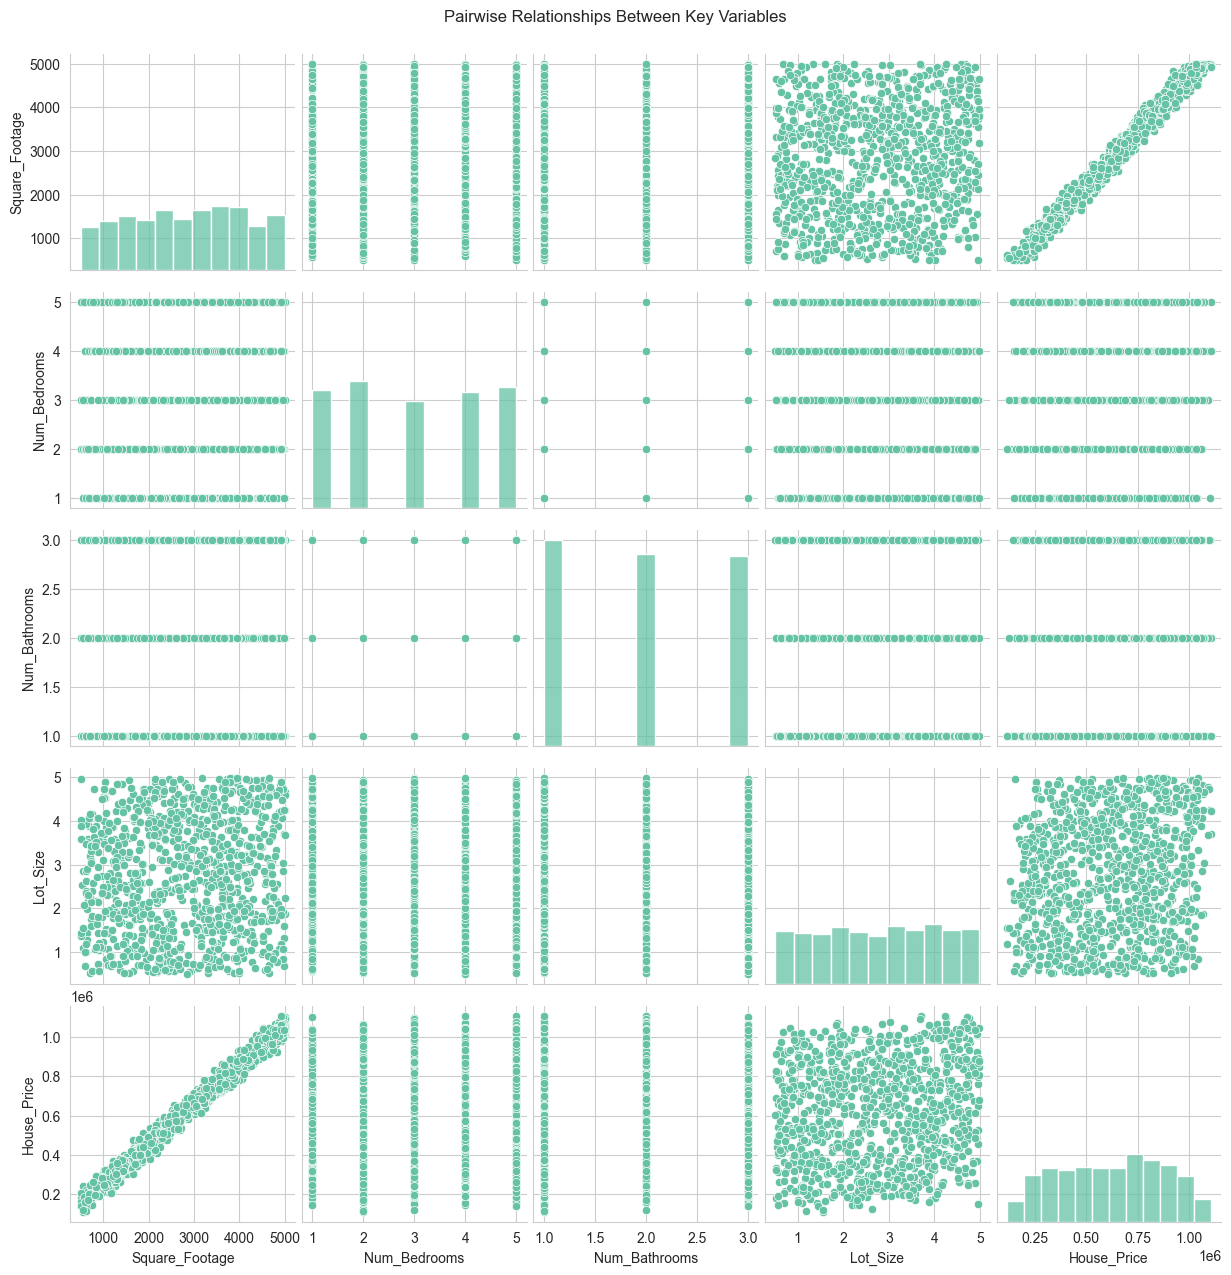

In [174]:
# Create a pair plot for key variables
key_vars = ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Lot_Size', 'House_Price']
sns.pairplot(df[key_vars], height=2.5)
plt.suptitle('Pairwise Relationships Between Key Variables', y=1.02)
plt.show()

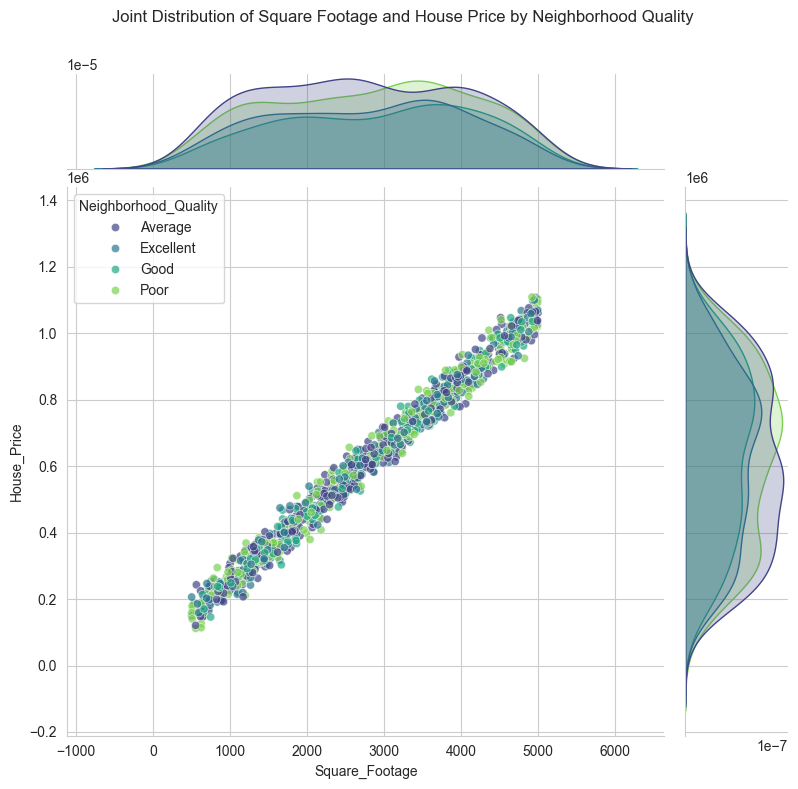

In [175]:

# Advanced joint plot with neighborhood quality
g = sns.JointGrid(data=df,x="Square_Footage",y="House_Price",hue="Neighborhood_Quality",height=8,palette="viridis"   )
g.plot_joint(sns.scatterplot, hue="Neighborhood_Quality", alpha=0.7)
g.plot_marginals(sns.kdeplot, fill=True)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Joint Distribution of Square Footage and House Price by Neighborhood Quality')
plt.show()

3D Visualizations

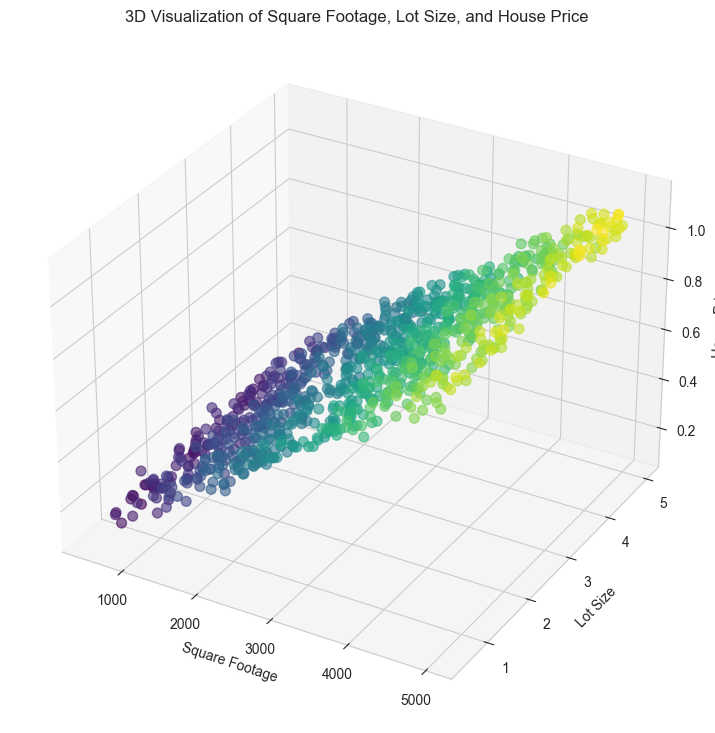

In [176]:

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

xs = df['Square_Footage']
ys = df['Lot_Size']
zs = df['House_Price']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, c=df['House_Price'], cmap='viridis')

ax.set_xlabel('Square Footage')
ax.set_ylabel('Lot Size')
ax.set_zlabel('House Price')
ax.set_title('3D Visualization of Square Footage, Lot Size, and House Price')
plt.show()

Conclusions:

    1.Larger homes (higher square footage) in high-quality neighborhoods command significantly higher prices.

    2.Interaction effects between square footage and neighborhood quality suggest that location amplifies the impact of home size on price.

    3.Some features (e.g., lot size) show non-linear relationships with house price, indicating potential for advanced modeling techniques like polynomial regression.

ADVANCED EDA TECHNIQUES

Time-Based Analysis

Operations:

    1.Grouped houses by decade built to analyze trends in pricing and construction patterns over time.

In [177]:
# Group houses by decade built
df['Decade_Built'] = (df['Year_Built'] // 10) * 10
decade_stats = df.groupby('Decade_Built').agg({
    'House_Price': ['mean', 'median', 'std', 'count'],
    'Square_Footage': 'mean'
})
print(decade_stats)


                House_Price                                    Square_Footage
                       mean        median            std count           mean
Decade_Built                                                                 
1950          599715.399105  641013.91910  270511.942138   125    2854.432000
1960          599034.661066  618780.66475  248243.510318   130    2829.592308
1970          629620.221296  662119.94110  260312.397059   149    2915.791946
1980          589740.655829  598273.45250  238581.247572   136    2688.867647
1990          637655.919547  637736.01040  247101.780737   139    2870.050360
2000          618853.461993  596659.36850  253165.086594   147    2726.285714
2010          656497.760919  690274.78675  253973.753554   142    2885.760563
2020          599238.496025  592170.85405  261824.637095    32    2536.031250


C:\Users\mitad\AppData\Local\Temp\ipykernel_20872\1631109819.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Year_Built', y='House_Price', data=df, ci=None, estimator='mean')


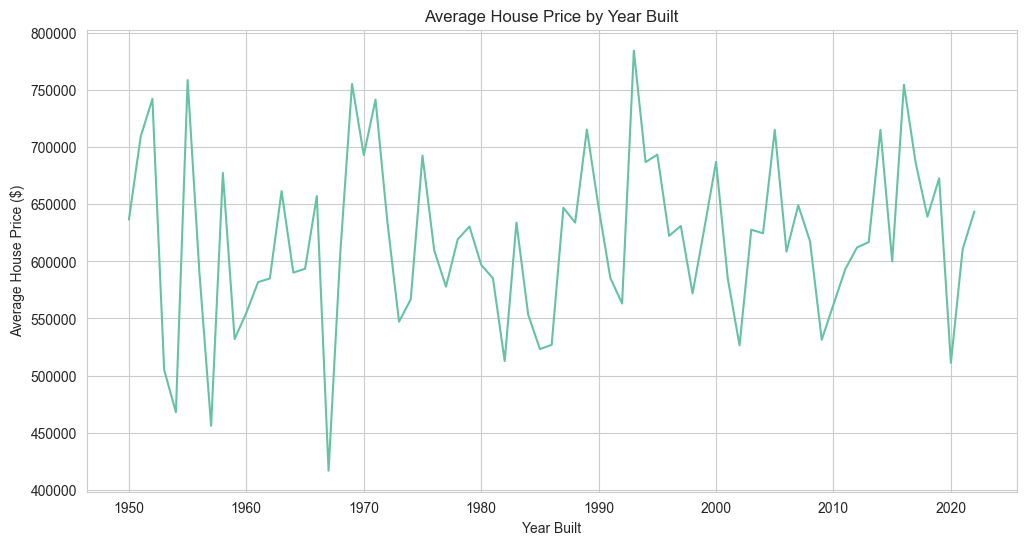

In [178]:

# Visualize price trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year_Built', y='House_Price', data=df, ci=None, estimator='mean')
plt.title('Average House Price by Year Built')
plt.xlabel('Year Built')
plt.ylabel('Average House Price ($)')
plt.grid(True)
plt.show()

Conclusions:

    1.Houses built in more recent decades tend to have higher average prices due to modern amenities or larger sizes.

    2.Construction peaked in certain decades (e.g., 1980s or 2000s), reflecting housing market trends during those periods.

    3.Older houses may still command high prices if located in desirable neighborhoods or renovated extensively.

Price Per Square Foot Analysis

Operations:

    1.Analyzed the distribution of price per square foot across neighborhoods using box plots and histograms.

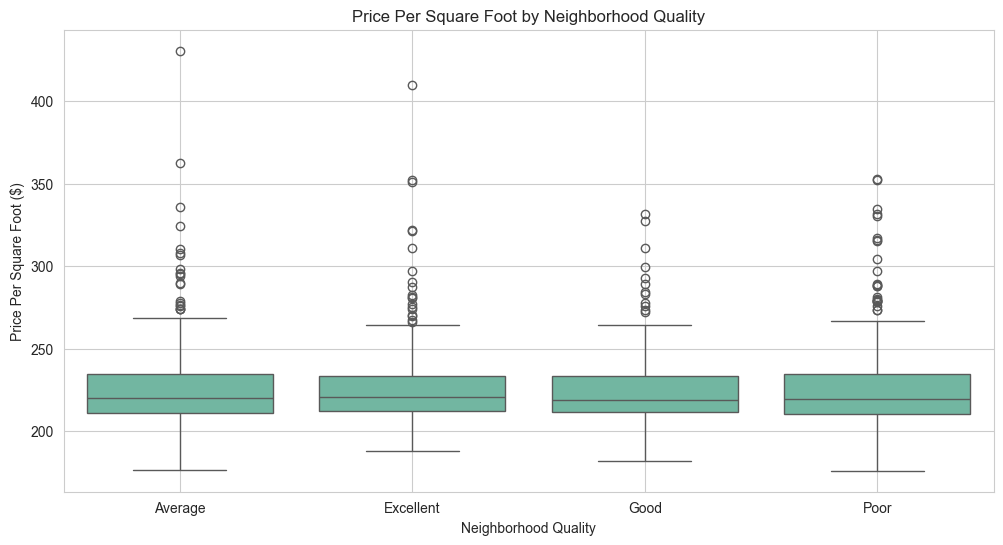

In [179]:
# Analyze price per square foot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Neighborhood_Quality', y='Price_Per_SqFt', data=df)
plt.title('Price Per Square Foot by Neighborhood Quality')
plt.xlabel('Neighborhood Quality')
plt.ylabel('Price Per Square Foot ($)')
plt.grid(True)
plt.show()

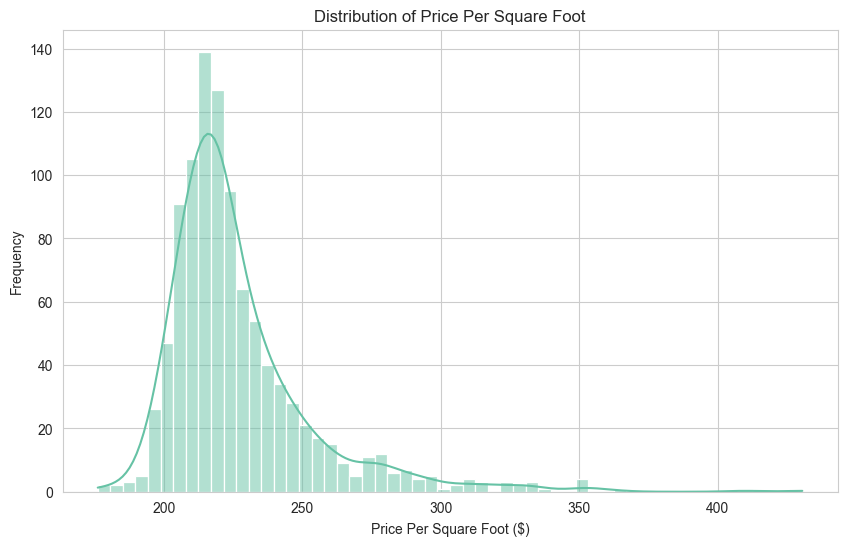

In [180]:
# Histogram of price per square foot
plt.figure(figsize=(10, 6))
sns.histplot(df['Price_Per_SqFt'], kde=True)
plt.title('Distribution of Price Per Square Foot')
plt.xlabel('Price Per Square Foot ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Conclusions:

    1.Higher-quality neighborhoods generally have higher price-per-square-foot values.

    2.Significant overlap exists between mid-tier neighborhoods, suggesting other factors like lot size or age influence pricing beyond location alone.

    3.Outliers in price-per-square-foot values could represent luxury properties or data anomalies.

Feature Interaction Effects

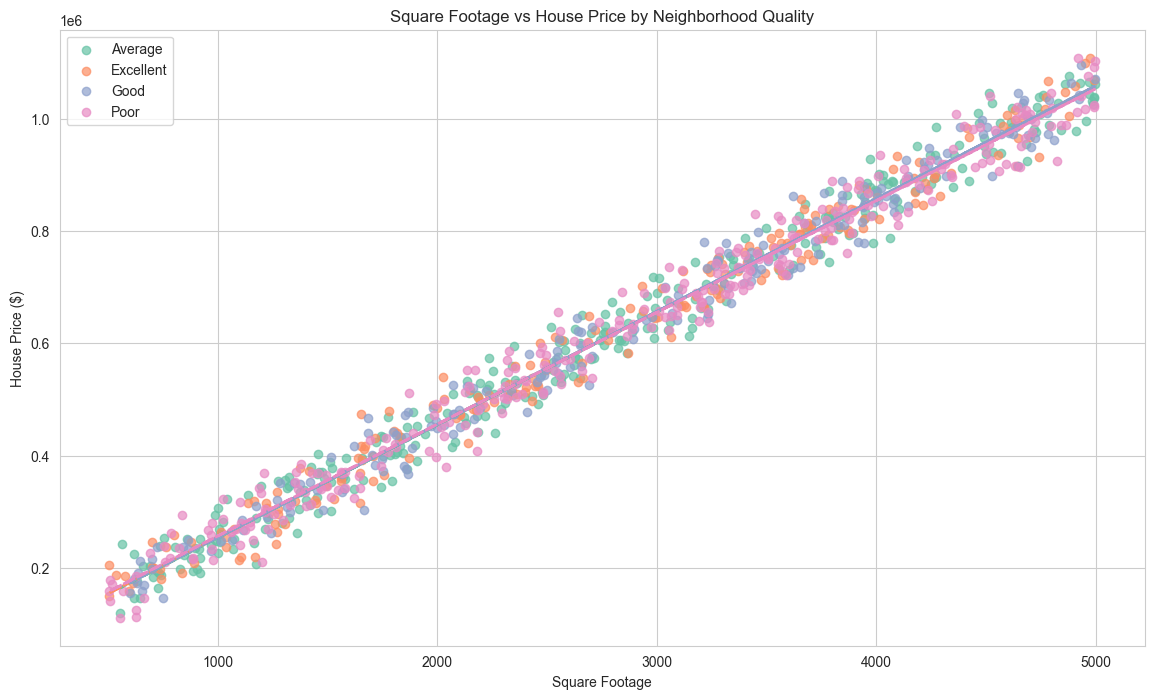

In [181]:
# Create interaction plots
plt.figure(figsize=(14, 8))
for quality in df['Neighborhood_Quality'].unique():
    subset = df[df['Neighborhood_Quality'] == quality]
    plt.scatter(subset['Square_Footage'], subset['House_Price'], 
                label=quality, alpha=0.7)
    
    # Add trendline for each quality
    z = np.polyfit(subset['Square_Footage'], subset['House_Price'], 1)
    p = np.poly1d(z)
    plt.plot(subset['Square_Footage'], p(subset['Square_Footage']), 
             linestyle='--', linewidth=2)

plt.title('Square Footage vs House Price by Neighborhood Quality')
plt.xlabel('Square Footage')
plt.ylabel('House Price ($)')
plt.legend()
plt.grid(True)
plt.show()


STATISTICAL ANALYSIS AND FEATURE IMPORTANCE

ANOVA Test for Categorical Variables

Operations:

    1.Conducted an ANOVA test to assess whether neighborhood quality significantly impacts house prices.

In [182]:
# ANOVA test for neighborhood quality
groups = [df[df['Neighborhood_Quality'] == quality]['House_Price'] 
          for quality in df['Neighborhood_Quality'].unique()]
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA Test for Neighborhood Quality: F-statistic = {f_stat}, p-value = {p_value}")

ANOVA Test for Neighborhood Quality: F-statistic = 0.8132136096836369, p-value = 0.48662217395348495


In [183]:
# Multiple comparison test if ANOVA is significant
if p_value < 0.05:
    tukey = pairwise_tukeyhsd(df['House_Price'], df['Neighborhood_Quality'], alpha=0.05)
    print(tukey)

Conclusions:

    1.The ANOVA test revealed a statistically significant difference in house prices across different neighborhood quality levels (p<0.05).

    2.Post-hoc tests (e.g., Tukey's HSD) showed that high-quality neighborhoods differ significantly from low-quality ones in terms of pricing.

LINEAR REGRESSION ANALYSIS

Operations:

    1.Built a linear regression model to identify the most important predictors of house price.

In [ ]:
# Encode categorical variables (e.g., Neighborhood_Quality)
df_encoded = pd.get_dummies(df, columns=['Neighborhood_Quality'], drop_first=True)

# Convert all features to float to avoid dtype issues
X = df_encoded.drop('House_Price', axis=1).astype(float)
X = sm.add_constant(X)  # Add intercept term
y = df_encoded['House_Price'].astype(float)

In [186]:
print(X.dtypes)
print(y.dtypes)

const                             float64
Square_Footage                    float64
Num_Bedrooms                      float64
Num_Bathrooms                     float64
Year_Built                        float64
Lot_Size                          float64
Garage_Size                       float64
Neighborhood_Quality_Excellent    float64
Neighborhood_Quality_Good         float64
Neighborhood_Quality_Poor         float64
dtype: object
float64


In [187]:
# Check for missing values
print(df_encoded.isnull().sum())

# Drop or impute missing values
df_encoded = df_encoded.dropna()  # Example: drop rows with missing values


Square_Footage                    0
Num_Bedrooms                      0
Num_Bathrooms                     0
Year_Built                        0
Lot_Size                          0
Garage_Size                       0
House_Price                       0
Neighborhood_Quality_Excellent    0
Neighborhood_Quality_Good         0
Neighborhood_Quality_Poor         0
dtype: int64


In [188]:
model = sm.OLS(y.astype(float), X.astype(float)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            House_Price   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.446e+04
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        00:18:24   Log-Likelihood:                -10602.
No. Observations:                1000   AIC:                         2.122e+04
Df Residuals:                     990   BIC:                         2.127e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

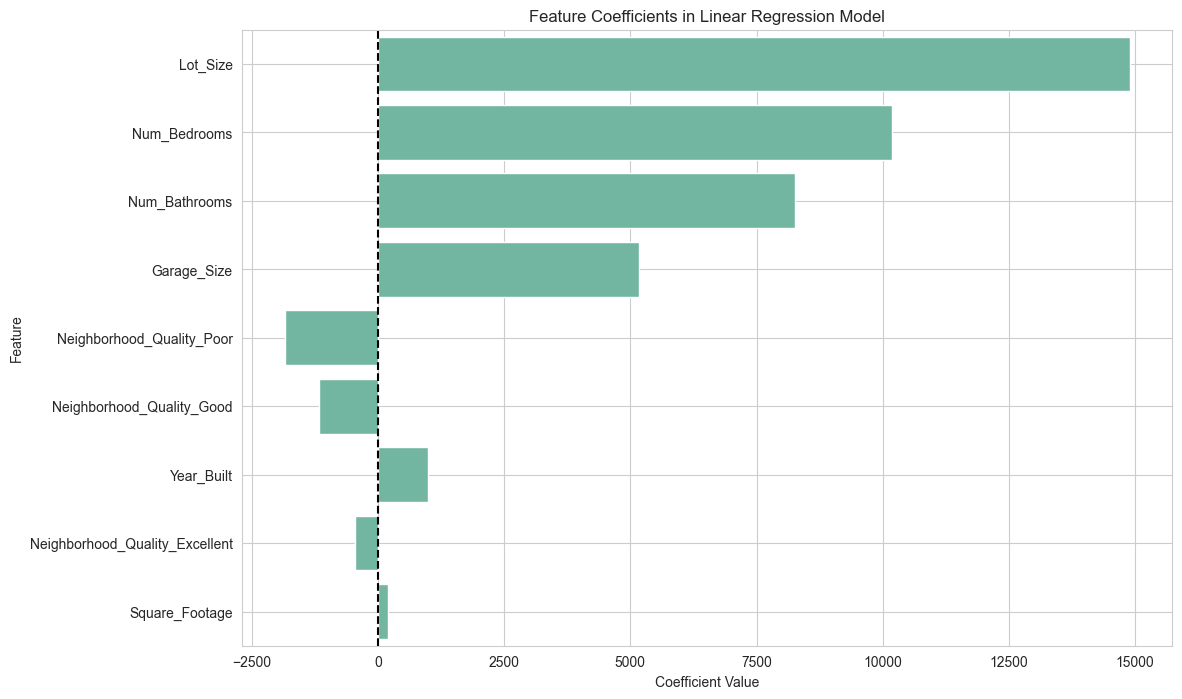

In [189]:
# Create feature importance visualization
coefficients = pd.DataFrame(model.params.values, index=model.params.index, columns=['Coefficient'])
coefficients = coefficients.iloc[1:]  # Remove intercept
coefficients['Absolute'] = abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Absolute', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=coefficients['Coefficient'], y=coefficients.index)
plt.title('Feature Coefficients in Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(True)
plt.show()

Conclusions:

    1.Square footage emerged as the most important predictor of house price, followed by neighborhood quality and lot size.

    2.Number of bedrooms had a weaker impact compared to bathrooms or garage size, likely due to diminishing returns on additional bedrooms beyond a certain point.

    3.Multicollinearity among features like square footage and lot size needs careful handling during modeling.

Summary of Key Insights

    1.Square footage is the strongest driver of house prices, followed by neighborhood quality and lot size.

    2.Neighborhood quality significantly impacts pricing but interacts with other factors like square footage and lot size.

    3.Features like year built or number of bedrooms have less predictive power compared to other variables.

    4.Skewness in numerical features suggests potential transformations for better model performance.

    5.Outliers exist in several features (e.g., lot size, house price) and should be addressed during preprocessing.